In [1]:
import tensorflow as tf
from tensorflow.keras import layers,models
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping , ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.efficientnet import EfficientNetB7, preprocess_input
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [2]:
import zipfile
import os

with zipfile.ZipFile("Musical Instrument.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")


# Load the dataset from folder
Label the data, resize it and reshuffle the data

In [3]:
data_dir='/content/music_instruments'
image_size=(224,224)
batch_size=32  # Dataset would be loaded in 32 batch size to save time and memory instead of loading the data 1 by 1

train_ds=tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=42,  # seed=42 ensures the split between train and validation is always the same
    image_size=image_size,
    batch_size=batch_size

)

validation_ds=tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=image_size,
    batch_size=batch_size)

Found 1806 files belonging to 10 classes.
Using 1445 files for training.
Found 1806 files belonging to 10 classes.
Using 361 files for validation.


In [4]:
class_name=train_ds.class_names
print(class_name)

['accordion', 'banjo', 'drum', 'flute', 'guitar', 'harmonica', 'saxophone', 'sitar', 'tabla', 'violin']


# Optimizing the Code


In [5]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) # cacheStores the dataset in memory (or disk) after the first epoch.
# Why: So it doesn’t read and preprocess the images again in every epoch — saves time! and prefetch  Allows the model to fetch the next batch while the current one is being processed. and speeds up data preparation
validation_ds=validation_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Data Augmentation
Data augmentation creates slightly modified versions of your training images on-the-fly (during training) to:

1. Reduce overfitting.

2. Improve generalization.

3. Make the model more robust to real-world variations

In [6]:
data_augmentation=models.Sequential([  #The Sequential() model expects a list of layers in order to esecute in orderwise
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomZoom(0.1,),
    layers.RandomRotation(0.1)
])

In [7]:
# we use prepare_ds fun to perform augmentation and optimization at one step

AUTOTUNE=tf.data.AUTOTUNE  # Buffer to speed things up

def prepare_ds(ds,augment=False):
    ds=ds.map(lambda x,y:(data_augmentation(x,training=True),y),num_parallel_calls=AUTOTUNE) if augment else ds
    return ds.prefetch(buffer_size=AUTOTUNE)

train_ds=prepare_ds(train_ds,augment=True)  # Training set gets augmented because it's meant to learn from variety.
validation_ds=prepare_ds(validation_ds)   # Validation set is left untouched so you can evaluate performance on real data without randomness.


# Custom CNN Model

In [8]:
model=models.Sequential([
    #  Preprocessing Layers
    layers.Rescaling(1./255,input_shape=(224,224,3)),

    #Cov Layers + Max Pooling
    layers.Conv2D(32,(3,3),activation='relu'),
    layers.MaxPool2D(),  # Reduces image size by keeping only the most important features.

    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPool2D(),

    layers.Conv2D(128,(3,3),activation='relu'),
    layers.MaxPool2D(),

    layers.Flatten(),
    layers.Dense(128,activation='relu'), #A fully connected layer with 128 neurons to learn complex patterns.
    layers.Dropout(0.3), # Randomly turns off 30% of neurons during training to prevent overfitting.
    layers.Dense(len(class_name),activation='softmax') # softmax turns raw scores into probabilities for each class.

    ])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss=('sparse_categorical_crossentropy'),optimizer=optimizer,metrics=['accuracy'])

In [17]:
# Bascically checkpoint saves the best model based on accuracy
checkpoint_cb=ModelCheckpoint('best_model.h5',
                              save_best_only=True,
                              monitor='val_accuracy',
                              mode='max')

# Early stopping stops training early to avoid overfiting
early_stopping_cb=EarlyStopping(patience=5, #patience is a method Waits for 5 epochs without improvement before reducing.
                                restore_best_weights=True,
                                monitor='val_accuracy',
                                mode='min')
# Helps fine-tune the model when it's stuck and not improving.
reduce_lr_cb=ReduceLROnPlateau(patience=3,monitor='val_loss',factor=0.2,min_lr=1e-6)

callbacks=[checkpoint_cb,early_stopping_cb,reduce_lr_cb]

In [18]:
history=model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1998 - loss: 2.1587

46/46 ━━━━━━━━━━━━━━━━━━━━ 202s 4s/step - accuracy: 0.2002 - loss: 2.1582 - val_accuracy: 0.2659 - val_loss: 2.0375 - learning_rate: 0.0010
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2866 - loss: 2.0274

46/46 ━━━━━━━━━━━━━━━━━━━━ 189s 4s/step - accuracy: 0.2867 - loss: 2.0272 - val_accuracy: 0.3850 - val_loss: 1.9328 - learning_rate: 0.0010
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 200s 4s/step - accuracy: 0.3184 - loss: 1.9025 - val_accuracy: 0.3767 - val_loss: 1.8262 - learning_rate: 0.0010
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 210s 4s/step - accuracy: 0.3360 - loss: 1.8704 - val_accuracy: 0.3657 - val_loss: 1.8477 - learning_rate: 0.0010
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 198s 4s/step - accuracy: 0.3626 - loss: 1.8109 - val_accuracy: 0.3740 - val_loss: 1.7655 - learning_rate: 0.0010
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3971 - loss: 1.7613

46/46 ━━━━━━━━━━━━━━━━━━━━ 196s 4s/step - accuracy: 0.3969 - loss: 1.7611 - val_accuracy: 0.4321 - val_loss: 1.6214 - learning_rate: 0.0010


In [15]:
def plot_training_history(history):

    acc = history.history.get('accuracy')
    val_acc = history.history.get('val_accuracy')
    loss = history.history.get('loss')
    val_loss = history.history.get('val_loss')

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Val Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


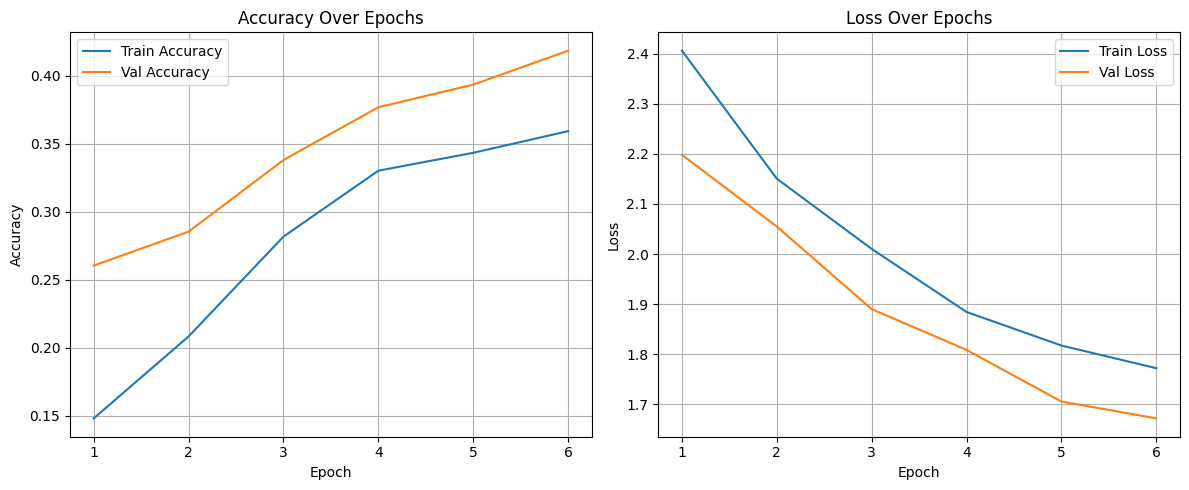

In [16]:
plot_training_history(history)

# MobileNetV2

In [22]:
mobilenet_base=MobileNetV2(weights='imagenet',include_top=False,input_shape=(224,224,3))

mobile_model=models.Sequential([
    layers.Rescaling(1./255,input_shape=(224,224,3)),
    mobilenet_base,
    layers.GlobalAveragePooling2D(), #This layer compresses the feature maps (which come out of MobileNet) into a single vector per image.
    layers.Dense(128,activation='relu'),
      layers.Dropout(0.3),  # Randomly “turns off” 50% of neurons during training.
    layers.Dense(len(class_name),activation='softmax')


])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Fine Tuning the MobileNetV2 model

In [24]:
mobilenet_base.trainable=True   # by default all training is freeze bcoz u loaded pretrained model like imagenet, this unfreezes to train and improve accuracy
for layers in mobilenet_base.layers[:100]:
  layers.trainable=False
# Even though you unfreezed all layers above, here you're freezing the first 100 layers again. These early layers detect very general features (like edges, curves, etc.) which are already useful and don’t need re-training.
mobile_model.compile(loss=('sparse_categorical_crossentropy'),# sparse_categorical_crossentropy is used for multi-class classification with integer labels.
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                     metrics=['accuracy'])


In [25]:
mobile_history = mobile_model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3434 - loss: 1.9975

46/46 ━━━━━━━━━━━━━━━━━━━━ 161s 3s/step - accuracy: 0.3471 - loss: 1.9875 - val_accuracy: 0.7922 - val_loss: 0.6806 - learning_rate: 1.0000e-04
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7945 - loss: 0.6992

46/46 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - accuracy: 0.7950 - loss: 0.6974 - val_accuracy: 0.8476 - val_loss: 0.4737 - learning_rate: 1.0000e-04
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8839 - loss: 0.4032

46/46 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - accuracy: 0.8839 - loss: 0.4028 - val_accuracy: 0.8532 - val_loss: 0.4282 - learning_rate: 1.0000e-04
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9283 - loss: 0.2608

46/46 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.9281 - loss: 0.2613 - val_accuracy: 0.8615 - val_loss: 0.4088 - learning_rate: 1.0000e-04
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9345 - loss: 0.2256

46/46 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.9344 - loss: 0.2259 - val_accuracy: 0.8698 - val_loss: 0.4218 - learning_rate: 1.0000e-04
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9586 - loss: 0.1677

46/46 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.9585 - loss: 0.1676 - val_accuracy: 0.8809 - val_loss: 0.3500 - learning_rate: 1.0000e-04


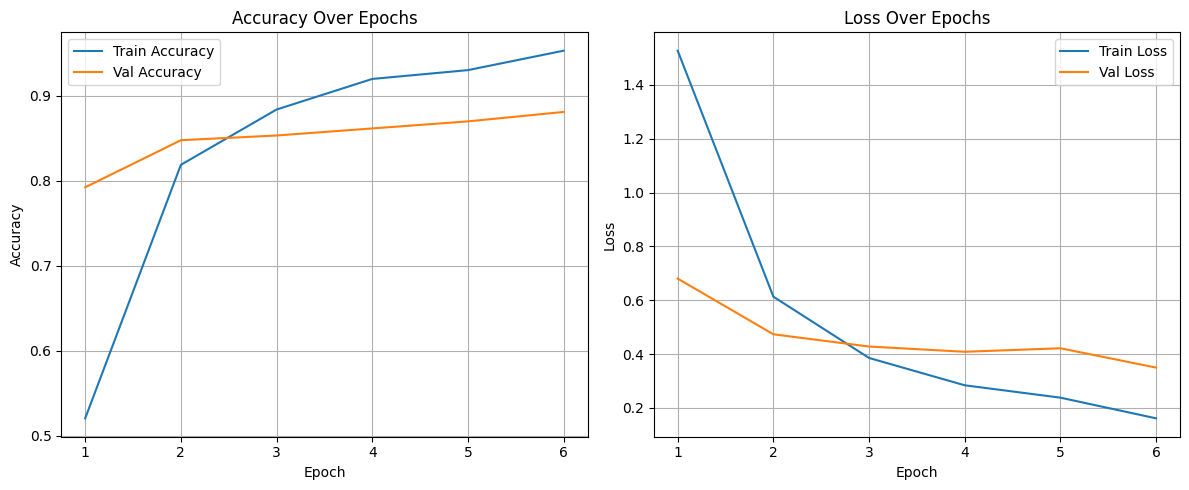

In [26]:
plot_training_history(mobile_history)